# Task 4: Time Series
Time series data, which is a sequence of observations recorded over time, is ubiquitous in various domains such as finance, economics, weather forecasting, and many more. Analyzing time series data allows us to uncover patterns, trends, and make predictions based on historical observations.

In this notebook, we will explore fundamental concepts and techniques for time series analysis using Python. We will cover topics like data visualization, trend analysis, motifs, anomalies and shapelets detection.

In [2031]:
import statistics 
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import metrics

In [2032]:
path_to_datasets = '../datasets'
path_to_cleaned = '/datasets_cleaned'

join_dataframe = pd.read_csv(f'{path_to_datasets}{path_to_cleaned}/join_dataframe.csv')
join_external_dataframe = pd.read_csv(f'{path_to_datasets}{path_to_cleaned}/join_external_dataframe.csv')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

### Filtering Small Cities
Like requested, we aim to extract a time series for each city from the incidents dataset, focusing on incidents that occurred in the years 2014, 2015, 2016, and 2017. The objective is to compute a score for each week across these four years. This score, which can be based on an existing index or a new one, will serve as a representation of the severity or frequency of incidents for a given city during a specific week.

To enhance the robustness of our analysis, we will filter out cities with a low number of weeks containing incidents. Specifically, we will exclude cities that have fewer than 15% of the total number of weeks with incidents over the four-year period. This ensures that we focus on cities with a relatively significant occurrence of incidents, providing more meaningful insights into their time series patterns.

By following these steps, we aim to create informative time series data for each city, capturing the temporal dynamics of incidents and enabling further analysis and interpretation of patterns and trends.

In [2033]:
filter_year_incidents = join_dataframe[join_dataframe['year'].isin([2014, 2015, 2016, 2017])].copy()

# Calculate minimum weeks required
total_weeks_in_4_years = 209
threshold_percentage = 15
min_weeks_required = total_weeks_in_4_years * (threshold_percentage / 100)

# Calculate total incidents per city per week
total_incidents = filter_year_incidents.groupby(['state', 'city_or_county', 'year', 'week']).size().reset_index(name='total_incidents')

# Calculate total weeks per city
total_weeks_per_city = total_incidents.groupby(['state', 'city_or_county']).size().reset_index(name='total_weeks')

# Filter cities based on minimum weeks required
filtered_cities = total_weeks_per_city[total_weeks_per_city['total_weeks'] >= min_weeks_required].copy()

# Filter incidents based on filtered cities
filtered_incidents = filter_year_incidents[filter_year_incidents['city_or_county'].isin(filtered_cities['city_or_county'])].copy()

### Severity Score

In this cell, we calculate a severity score for each incident in the filtered_incidents DataFrame based on various weighted factors. The severity score is determined by considering the number of participants involved in each incident and assigning weights to different outcomes.

The weights for each outcome are defined as follows:

- weight_injured: 3
- weight_arrested: 2
- weight_unharmed: -2
- weight_participants: 0.5

The severity score is computed using a weighted sum of the counts of injured, arrested, and unharmed participants, where each count is multiplied by its respective weight. The total severity score for each incident is then calculated by multiplying this weighted sum with the number of participants and the weight assigned to participants.

This scoring mechanism provides a quantitative representation of the severity of incidents, taking into account the different types and quantities of outcomes. The resulting severity_score column in the filtered_incidents DataFrame reflects the aggregated severity for each incident, aiding in further analysis and interpretation of the dataset. Adjustments to the weights can be made to customize the scoring system based on specific considerations or priorities.

In [2034]:
# Calculate severity score
weight_injured = 2
weight_arrested = 3
weight_unharmed = -3
weight_participants = 0.5
filtered_incidents['severity_score'] = (
    weight_participants * filtered_incidents['n_participants'] * (
    weight_injured * filtered_incidents['n_injured'] +
    weight_arrested * filtered_incidents['n_arrested'] +
    weight_unharmed * filtered_incidents['n_unharmed']
    )
)

# Identify incidents with at least one person killed
filtered_incidents['isKilled'] = filtered_incidents['n_killed'] != 0

# Create a 'year_week' column for sorting
filtered_incidents['year_week'] = list(zip(filtered_incidents['year'], filtered_incidents['week']))
filtered_incidents = filtered_incidents.sort_values(by='year_week')

In [2035]:
filtered_incidents.head()

,year,month,week,day,state,congressional_district,city_or_county,latitude,longitude,incidents_state_year,incidents_city_year,severity_index,n_participants,n_killed,n_injured,n_unharmed,n_arrested,percentage_males,percentage_adults,age_range_indicator,age_combined_index,incident_characteristics1,povertyPercentage,poverty_difference,poverty_comparison,party,percentage_votes,severity_score,isKilled,year_week
39844,2014,1,1,1,Texas,27.0,Corpus Christi,27.7515,-97.4432,1436,138,0.5,2.0,0.0,1.0,1.0,0.0,100.0,100.0,15.0,34.25,Shot - Wounded/Injured,14.9,11.2,Above US Average,REPUBLICAN,63.597030,-1.0,False,"(2014, 1)"
155563,2014,1,1,4,Maryland,7.0,Columbia,39.2147,-76.8717,451,4,0.0,2.0,0.0,0.0,2.0,0.0,50.0,100.0,5.0,25.75,Armed robbery with injury/death and/or evidenc...,8.9,5.2,Below US Average,DEMOCRAT,69.938446,-6.0,False,"(2014, 1)"
63379,2014,1,1,4,Pennsylvania,2.0,Philadelphia,39.9526,-75.1652,1402,782,0.5,2.0,0.0,1.0,1.0,0.0,50.0,100.0,10.0,31.00,Shot - Wounded/Injured,12.0,8.3,Below US Average,DEMOCRAT,87.703473,-1.0,False,"(2014, 1)"
84009,2014,1,1,1,Rhode Island,2.0,Providence,41.8253,-71.4143,104,73,1.0,2.0,0.0,2.0,0.0,0.0,100.0,100.0,3.0,23.75,Shot - Wounded/Injured,11.5,7.8,Below US Average,DEMOCRAT,62.221019,4.0,False,"(2014, 1)"
55478,2014,1,1,4,California,35.0,Pomona,34.0476,-117.7610,1733,15,0.5,2.0,0.0,1.0,1.0,0.0,50.0,100.0,5.0,29.75,Shot - Wounded/Injured,14.5,10.8,Above US Average,DEMOCRAT,63.451932,-1.0,False,"(2014, 1)"


In [2036]:
filtered_cities = filtered_incidents.pivot_table(index='city_or_county', columns=['year', 'week'], values='severity_score', aggfunc='sum', fill_value=-1)

In [2037]:
filtered_cities.head()

year           2014                                                            \
week             1     2    3     4     5    6    7    8    9    10   11   12   
city_or_county                                                                  
Abilene        -1.0  -1.0 -1.0  -1.0  -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   
Aiken          -1.0 -12.0 -1.0  -1.0  -1.0 -1.0 -1.0 -1.0 -1.0 -3.0 -6.0 -1.5   
Akron          -1.0  -1.0 -1.0 -18.0  -1.0 -1.0 -1.0 -1.0 -1.0  1.5 -1.0 -6.0   
Albany          1.0  -1.0 -3.0  -1.0  -1.5 -1.0  7.0  1.0 -1.0 -1.0 -3.0 -1.0   
Albuquerque     1.0  -1.0 -1.0  -2.5 -13.5 -1.0 -1.0 -1.0 -6.0  1.5 -9.0  0.0   

year                                                                         \
week              13    14    15   16   17   18   19    20    21   22    23   
city_or_county                                                                
Abilene         -1.0  -1.0  -1.0 -1.0 -1.0 -1.0 -1.0  -1.0  -1.0  5.0  10.5   
Aiken           -1.0  -1.0  -1.0 -1.0 -1.0 -1.0 -2.0  -1.0  -1.0 -1.0   0.0   
Akron           -6.0 -13.5 -14.0 -6.0 -1.0 -1.0 -1.5  -1.0  -2.0 -6.0 -30.0   
Albany         -12.5  -1.0   2.5 -5.0  2.0 -7.5  2.5 -21.0 -24.0  1.0  -9.5   
Albuquerque     -1.0  -1.0  -1.0 -1.0  0.0 -1.0 -1.0  -1.0  -6.0 -1.0  -1.0   

year                                                                          \
week             24   25   26   27    28    29    30    31    32    33    34   
city_or_county                                                                 
Abilene         6.0 -1.0 -1.0 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0 -13.5  -1.0   
Aiken          -1.0 -1.0 -1.0 -1.0  -1.0  -1.0  -1.0 -30.0  -1.0  -1.0  -1.0   
Akron           0.0 -5.0 -1.0 -6.5 -31.0  -8.0 -23.5 -25.5 -13.5 -24.0  18.0   
Albany         -1.0  5.0  2.0  1.0   1.5 -24.0  -4.0   0.0  -1.0  -1.0  -1.5   
Albuquerque    -1.0 -1.0 -7.5 -1.5  -1.0  -9.0 -15.0  -9.0 -28.5 -10.0 -43.5   

year                                                                         \
week             35    36   37    38    39    40   41    42    43   44   45   
city_or_county                                                                
Abilene        -1.0  -6.0 -1.0  -1.0  -1.0  -1.0 -1.0  -1.0  -1.0  6.0 -1.0   
Aiken          -1.0  -1.0 -1.0  -1.0  -1.0  -1.5 -1.5  -5.0   0.0 -1.0 -1.0   
Akron          -1.0 -10.0 -8.0  -1.0  -1.5  -3.0 -1.0  -1.0  -1.0 -1.0  0.0   
Albany         -3.0   0.5 -1.0 -14.5 -10.5  -5.0 -1.0 -18.0  -7.0 -2.5  1.0   
Albuquerque    -9.0  -2.0 -1.0  -2.5 -15.0 -13.5  6.0  -3.0 -11.5 -0.5 -1.0   

year                                                2015                  \
week              46   47   48   49   50    51   52   1    2    3     4    
city_or_county                                                             
Abilene         -1.0 -1.0 -1.0 -1.0 -1.0  -1.0  9.0 -1.0 -1.0 -1.0  -1.0   
Aiken           -1.0  0.0 -1.0  1.0  1.5  -1.0  1.5 -1.0  2.5 -1.0   6.5   
Akron           30.0 -1.0 -1.0 -1.5 -1.0   1.5 -1.0  1.5  1.5  5.0  12.0   
Albany          -6.0 -1.0 -1.0 -1.0  2.0   2.5  1.5  1.5  1.5  1.5   1.0   
Albuquerque     -1.0 -3.0 -2.0 -1.0 -1.0  16.5  3.0  1.0  1.0  3.0   2.5   

year                                                                         \
week              5     6    7    8    9     10    11    12   13    14   15   
city_or_county                                                                
Abilene         -1.0  -1.0 -1.0 -1.0 -1.0   1.0  -1.0  -1.0 -1.0  -1.0 -1.0   
Aiken           -6.0  21.0 -1.0  1.5  7.5  12.0   1.5 -24.0 -1.0 -20.0 -1.0   
Akron           -1.0  -1.0  9.0 -1.0 -1.5  -1.0  -1.0  -4.0 -4.5 -10.5 -6.0   
Albany           1.5   0.0 -1.0 -1.0  1.5   7.0   1.5   1.5 -1.0   1.0 -1.0   
Albuquerque     43.5  -9.0  3.0  3.0  3.0   1.5  15.5   1.5  1.5   1.5  8.0   

year                                                                         \
week              16    17   18    19   20    21    22    23   24   25   26   
city_or_county                              

### Classes
Here we create this dataframe that we will use in the last section **Shapelet discovery**.
This is crucial as we need each time series to be classified as either *Killed* or *No Killed* to then run our model.

We can see below that we define this labels by calculating how much more the weeks having incidents with dead people are then the others and we adjust this balancing factor so that the 2 labels are balanced, in order to then use the accuracy of the model as a reliable method to calculate its quality.

In [2038]:
# Create a DataFrame to store the final results
result_df = pd.DataFrame(index=filtered_cities.index)

# Determine if more than half of the incidents in a city involve killings
threshold = filtered_incidents.groupby('city_or_county')['isKilled'].mean().mean()

result_df['isKilled'] = filtered_incidents.groupby('city_or_county')['isKilled'].mean() > threshold- 0.023

result_df['isKilled'].value_counts()

isKilled
False    233
True     233
Name: count, dtype: int64

### Time Series Analysis

We need to have all the data as attributes of the dataframe to better work with certain algorithm and is for this reason that we create the dataframe *time_series*.

In [2039]:
time_series = filtered_cities.stack(level=['year', 'week'])

time_series = time_series.reset_index()

time_series.columns = ['city_or_county', 'year', 'week', 'severity_score']

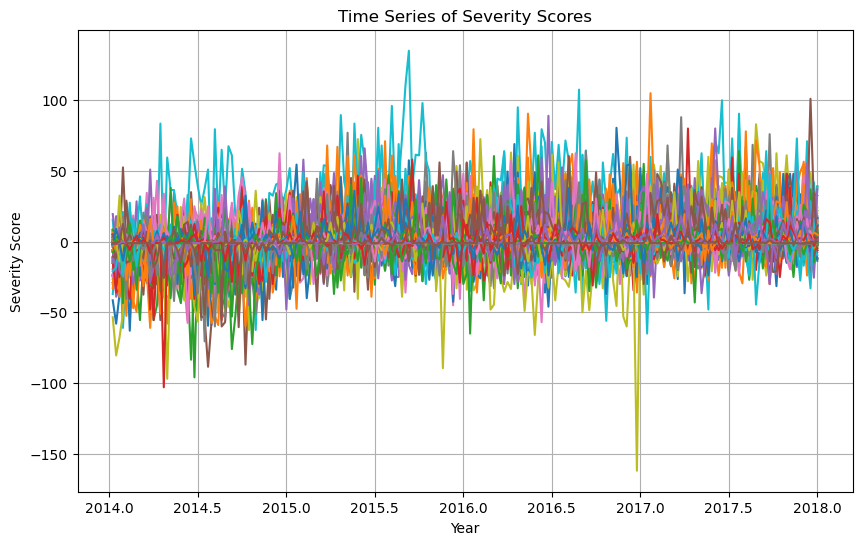

In [2040]:
plt.figure(figsize=(10, 6))
for city in time_series['city_or_county'].unique():
    city_data = time_series[time_series['city_or_county'] == city]
    plt.plot(city_data['year'] + city_data['week'] / 52, city_data['severity_score'], label=city)

plt.title('Time Series of Severity Scores')
plt.xlabel('Year')
plt.ylabel('Severity Score')
plt.grid(True)
plt.show()

### Offset Translation

In [2041]:
time_series_analysed = time_series.copy()

avg_severity_by_city = time_series_analysed.groupby('city_or_county')['severity_score'].transform('mean')

time_series_analysed['severity_score'] = time_series_analysed['severity_score'] - avg_severity_by_city

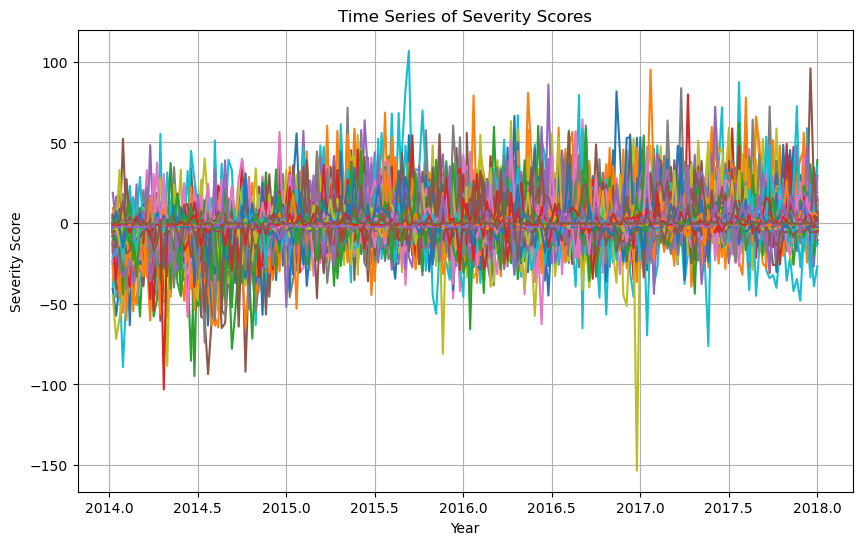

In [2042]:
plt.figure(figsize=(10, 6))
for city in time_series_analysed['city_or_county'].unique():
    city_data = time_series_analysed[time_series_analysed['city_or_county'] == city]
    plt.plot(city_data['year'] + city_data['week'] / 52, city_data['severity_score'], label=city)

plt.title('Time Series of Severity Scores')
plt.xlabel('Year')
plt.ylabel('Severity Score')
plt.grid(True)
plt.show()

### Amplitude Scaling

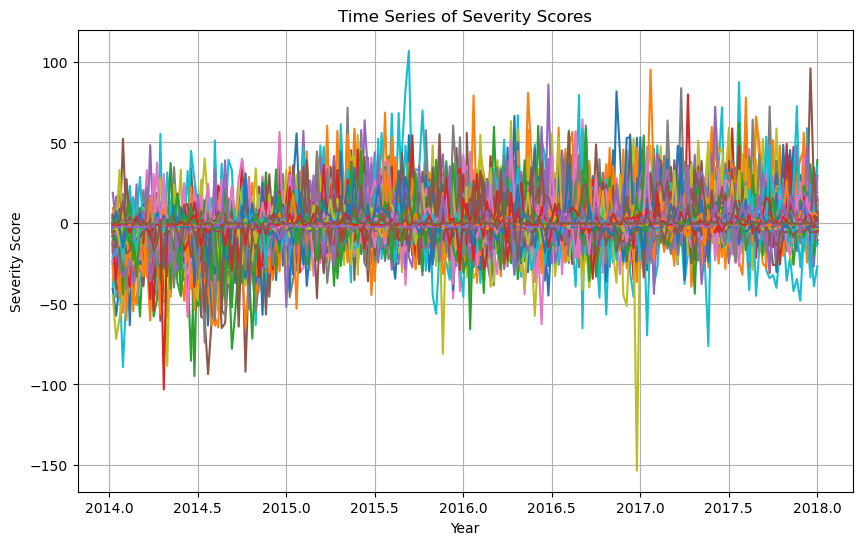

In [2043]:
plt.figure(figsize=(10, 6))
for city in time_series_analysed['city_or_county'].unique():
    city_data = time_series_analysed[time_series_analysed['city_or_county'] == city]
    plt.plot(city_data['year'] + city_data['week'] / 52, city_data['severity_score'], label=city)

plt.title('Time Series of Severity Scores')
plt.xlabel('Year')
plt.ylabel('Severity Score')
plt.grid(True)
plt.show()

### Linear Trend

In [2044]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.stats import linregress

We often hear that the passing of time worses everything and for this reason one thing that came to our minds was to start checking this fact.

Mythbusting this common misconception may not be crucial to our analysis but we thought that it was still interesting to look at.

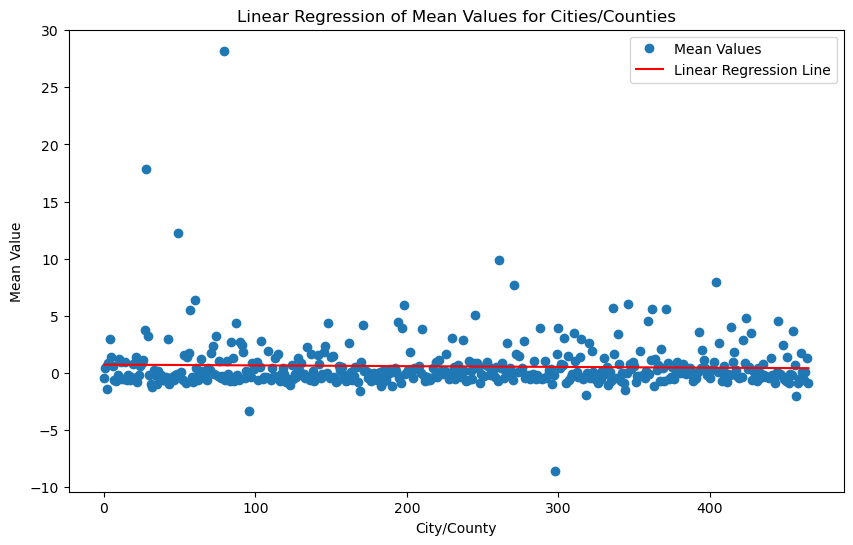

In [2045]:
# Calculate the mean for each city_or_county
mean_values = filtered_cities.mean(axis=1)

# Fit a linear regression line to the mean values
slope, intercept, _, _, _ = linregress(np.arange(len(mean_values)), mean_values)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot the mean values
plt.plot(np.arange(len(mean_values)), mean_values, marker='o', linestyle='', label='Mean Values')

# Plot the linear regression line
linear_regression_line = np.arange(len(mean_values)) * slope + intercept
plt.plot(np.arange(len(mean_values)), linear_regression_line, label='Linear Regression Line', color='red')

plt.legend()
plt.title('Linear Regression of Mean Values for Cities/Counties')
plt.xlabel('City/County')
plt.ylabel('Mean Value')
plt.show()

### Removing Trends

We will use Augmented Dickey-Fuller test to check stationarity or non-stationarity of timeseries. We find all timeseries that are not stationary using a threshold of 0.05 on the returned p-value.

In [2046]:
import warnings
from tqdm import tqdm 
from statsmodels.tsa.stattools import adfuller

In [2047]:
non_stationary_idx_list = []
with warnings.catch_warnings(record=True):
    for col in tqdm(filtered_cities.columns):
        adf = adfuller(filtered_cities[col])
        pvalue = adf[1]
        if pvalue > 0.05:
            non_stationary_idx_list.append(col)

100%|██████████| 209/209 [00:00<00:00, 285.60it/s]


In [2048]:
len(non_stationary_idx_list)

0

This proves that our timeseries has no trends.

### Removing Noise

To find the best sliding window for the noise we used the mean of the **sums of absolute differences (SAD)** between the original timeseries and the smoothed one, then we resorted to the elbow method to choose the best window that 'doesn't smooth too much' the original timeseries.

In [2049]:
noise_windows = np.array(range(1,21))
mean_sad_dict = dict()
for window_size in tqdm(noise_windows):
    sum_abs_diff_users = list()
    for city in filtered_cities.columns:
        # Calculate SAD for each user
        sum_abs_diff_single_per_user = np.sum(np.abs(filtered_cities[city].rolling(window=window_size, center = True, min_periods = 1).mean() - filtered_cities[city]))
        sum_abs_diff_users.append(sum_abs_diff_single_per_user)
    
    # Average the SAD for all users to get final SAD score
    mean_sad_dict[window_size] = np.average(sum_abs_diff_users)

100%|██████████| 20/20 [00:00<00:00, 27.72it/s]


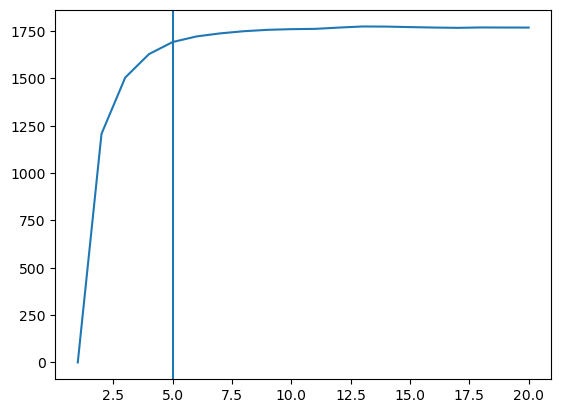

In [2050]:
plt.plot(mean_sad_dict.keys(), mean_sad_dict.values())
plt.axvline(5)
plt.show()

In [2051]:
window_size = 5

In [2052]:
# Function that denoises df of timeseries given a window size
def denoiser(df, window_size):
    denoised_df = df.apply(lambda ts : ts.rolling(window=window_size, center = True, min_periods = 1).mean())
    return denoised_df

In [2053]:
filtered_cities_denoised = denoiser(filtered_cities, window_size=window_size)

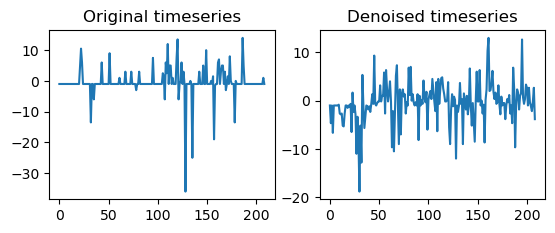

In [2054]:
ts_example = filtered_cities.loc['Abilene']
ts_example_denoised = filtered_cities_denoised.loc['Abilene']

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(ts_example.to_numpy())
ax1.set_title('Original timeseries')
ax1.set_box_aspect(3/4)

ax2.plot(ts_example_denoised.to_numpy())
ax2.set_title('Denoised timeseries')
ax2.set_box_aspect(3/4)

plt.show()

### Scaler with mean and std

In [2055]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [2056]:
filtered_cities_std = pd.DataFrame(columns=filtered_cities_denoised.columns)
scaler = TimeSeriesScalerMeanVariance(mu=0, std=1)
for col in filtered_cities_denoised.columns:
    filtered_cities_std[col] = scaler.fit_transform(filtered_cities_denoised[col].values.reshape(1, -1)).flatten()

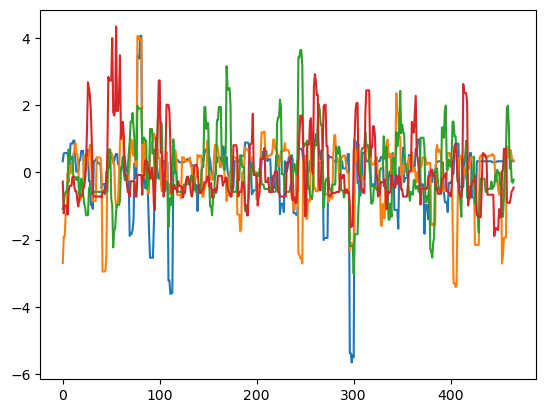

In [2057]:
ts_example_1 = filtered_cities_std.iloc[:, 16]
ts_example_2 = filtered_cities_std.iloc[:, 32]
ts_example_3 = filtered_cities_std.iloc[:, 64]
ts_example_4 = filtered_cities_std.iloc[:, 96]
plt.plot(ts_example_1.to_numpy())
plt.plot(ts_example_2.to_numpy())
plt.plot(ts_example_3.to_numpy())
plt.plot(ts_example_4.to_numpy())
plt.show()

In [2058]:
timeseries_data = np.transpose(filtered_cities_std.values)

## Clustering timeseries

In [2059]:
def print_clusters(y, K, model):
    print("k = ", K, "| Clusters =", np.unique(y,return_counts=True)[1], "| Inertia =", model.inertia_)

In [2060]:
def plot_timeseries_per_cluster(labels, n_clusters):
    fig, ax = plt.subplots(math.ceil(n_clusters/2), 2)
    print(np.shape(ax))
    colors = plt.rcParams["axes.prop_cycle"]()
    fig.set_size_inches(8, 8)

    max_num_samples_per_cluster = 5
    for c in range(n_clusters):
        cluster_index = [i for i, x in enumerate(labels) if x == c] 
        random_indexes = np.random.choice(
            cluster_index, size=min(len(cluster_index), max_num_samples_per_cluster), replace=False)
        cluster_sample = timeseries_data[random_indexes]
        
        ax_idx_row = math.ceil(c/2)-1
        ax_idx_col = c % 2
        ax_c = ax[ax_idx_row][ax_idx_col]
        color = next(colors)["color"]
        ax_c.set_title('Cluster: '+str(c), y=1.0, pad=-14)
        for ts in cluster_sample:
            ax_c.plot(ts, color=color)

    plt.show()

In [2062]:
dict_colors_bot = {1: 'teal', 0: 'sandybrown'}

def plot_is_killed_pieplots(labels, n_clusters):
    # Calculate the number of rows and columns for the subplot grid
    rows = int(np.ceil(n_clusters / 2))
    cols = 4

    # Create a subplot grid
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))

    # Flatten the 2D array of subplots into a 1D array
    axes = axes.flatten()

    for k in range(n_clusters):
        cluster_indices = np.where(labels == k)[0]
        cluster_df = result_df.iloc[cluster_indices]
        bot_for_cluster = cluster_df['isKilled'].value_counts()

        # Use the current subplot for the current cluster
        ax = axes[k]

        ax.set_title('Cluster: ' + str(k))
        ax.pie(bot_for_cluster, labels=bot_for_cluster.index, colors=[dict_colors_bot[v] for v in bot_for_cluster.index])

        # Adjust layout to prevent overlapping titles
        plt.tight_layout()

    # Remove any unused subplots
    for i in range(n_clusters, len(axes)):
        fig.delaxes(axes[i])

    # Show the plot
    plt.show()

### Shape-Based clustering
#### K-Means

In [2063]:
from tslearn.clustering import TimeSeriesKMeans

In [2064]:
with warnings.catch_warnings(record=True):
    inertia_euclidean = list()
    models_euclidean = list()

    metric = 'euclidean'
    print("Clusters sizes for each K with", metric, "metric:")

    for n_clusters in range(2, 21):
        # Build and fit Kmeans
        model = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, max_iter=10)
        model.fit(timeseries_data)
        y = model.predict(timeseries_data)
        # Print cluster and inertia info
        print_clusters(y, n_clusters, model)

        inertia_euclidean.append(model.inertia_)
        models_euclidean.append(model)

Clusters sizes for each K with euclidean metric:
k =  2 | Clusters = [ 46 163] | Inertia = 393.60440866394026
k =  3 | Clusters = [45 75 89] | Inertia = 381.3111333778858
k =  4 | Clusters = [59 45 37 68] | Inertia = 375.2326689455231


k =  5 | Clusters = [45 59 18 30 57] | Inertia = 373.83308328362585
k =  6 | Clusters = [34 48 47 31 15 34] | Inertia = 365.284331885348
k =  7 | Clusters = [30 34 37 23 34 30 21] | Inertia = 361.26824492198773
k =  8 | Clusters = [12 33 32 25 22 20 30 35] | Inertia = 358.7401298321549
k =  9 | Clusters = [14  6 23 42 30 13 18 21 42] | Inertia = 358.5158448130041
k =  10 | Clusters = [23 21  8 27 17 15 20 30 21 27] | Inertia = 350.6630176869785
k =  11 | Clusters = [18 15 33 24 19 20 14 15 12 20 19] | Inertia = 349.0180915488252
k =  12 | Clusters = [17 11 12 18 14 28 13 15 16 15 22 28] | Inertia = 347.4643754590203
k =  13 | Clusters = [25 19 20  7 20  8  7 21 23 17 14 11 17] | Inertia = 343.8605186860496
k =  14 | Clusters = [ 4 14 22 36 14  5 12  8 13  9 11 26 12 23] | Inertia = 340.44161828698907
k =  15 | Clusters = [ 9  6  8 20 23 14  9  7  3 21 19 17  5 26 22] | Inertia = 340.1916192253881
k =  16 | Clusters = [22  8 16  9 15 11  7  9 11 16 13 11 18 15 15 13] | Inertia = 337.599

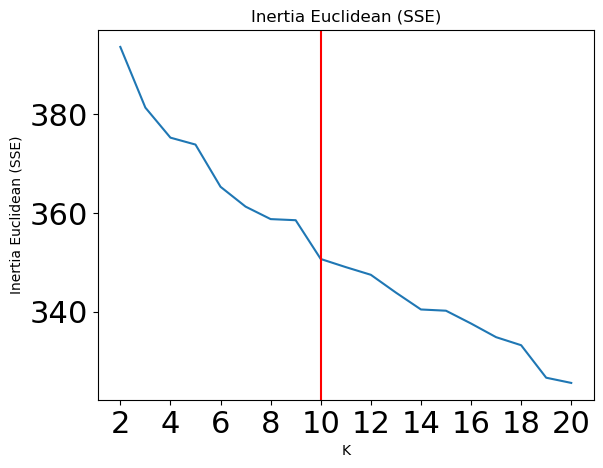

In [2065]:
plt.plot(range(2, len(inertia_euclidean) + 2), inertia_euclidean)
plt.ylabel('Inertia Euclidean (SSE)')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(np.arange(2,21,2))
plt.title('Inertia Euclidean (SSE)')
plt.axvline(10, color='r')
plt.show()

In [2066]:
euclidean_n_clusters = 10
euclidean_kmeans = models_euclidean[euclidean_n_clusters-2]

In [2067]:
silhouette_score = metrics.silhouette_score(timeseries_data, euclidean_kmeans.labels_, metric='euclidean')
print("Silhouette Score:", silhouette_score)

Silhouette Score: 0.015581299530557962


(5, 2)


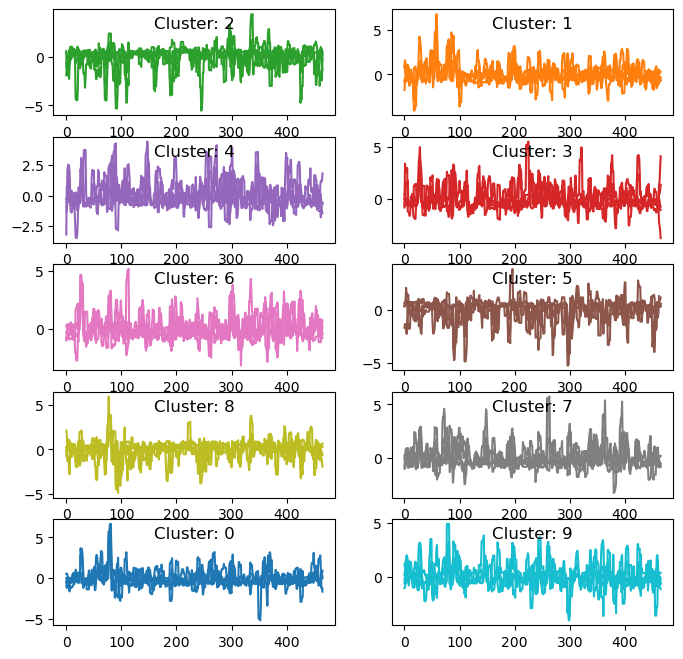

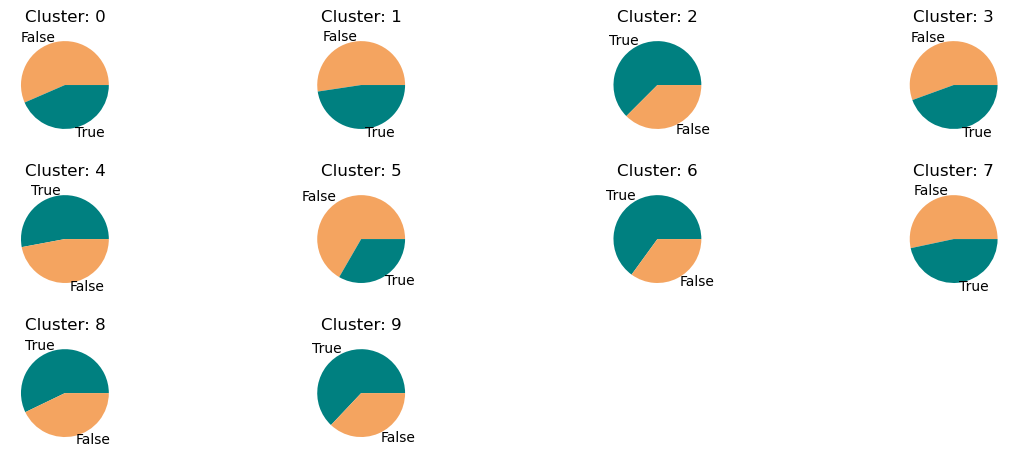

In [2068]:
plot_timeseries_per_cluster(euclidean_kmeans.labels_, euclidean_n_clusters)
plot_is_killed_pieplots(euclidean_kmeans.labels_, euclidean_n_clusters)

#### Dynamic Time Warping

In [2069]:
metric = 'dtw'
dtw_n_clusters = 10

In [2070]:
model = TimeSeriesKMeans(n_clusters=dtw_n_clusters, metric=metric, max_iter=10)
model.fit(timeseries_data)
y = model.predict(timeseries_data)
# Print cluster and inertia info
print("Clustering info for KMeans with", metric, "metric")
print_clusters(y, 10, model)

inertia_dtw = model.inertia_
model_dtw = model

/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 209 1-dimensional timeseries
  warnings.warn(


Clustering info for KMeans with dtw metric
k =  10 | Clusters = [18 19 42 22 10 20 40 15 10 13] | Inertia = 95.50454987795823


(5, 2)


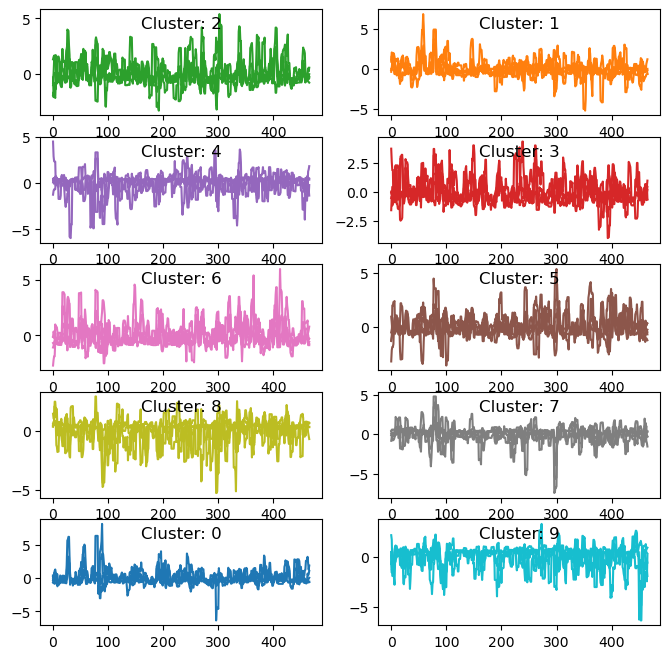

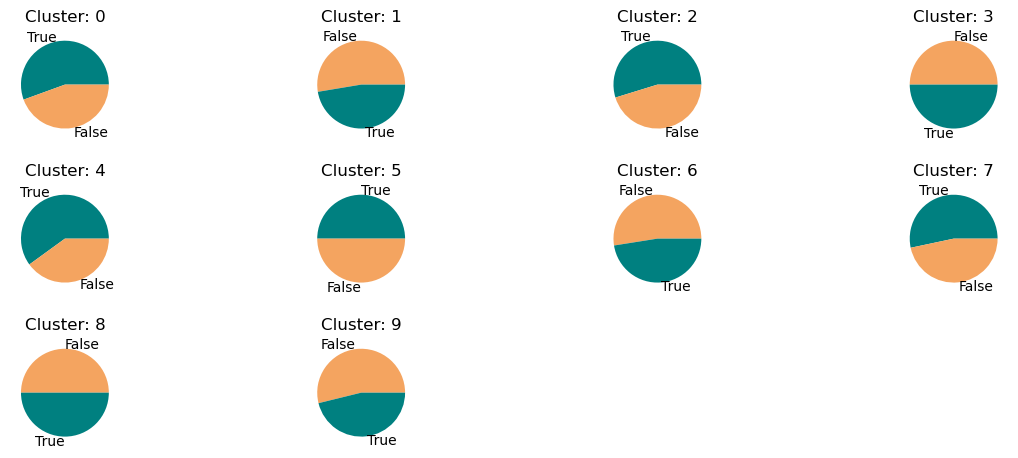

In [2071]:
plot_timeseries_per_cluster(model_dtw.labels_, dtw_n_clusters)
plot_is_killed_pieplots(model_dtw.labels_, dtw_n_clusters)

### Feature based clustering

In [2072]:
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2073]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }
    return features

Extract features from timeseries

In [2074]:
timeseries_features = [list(calculate_features(x).values())[:-2] for x in timeseries_data]

#### K-Means

Use minmax normalization for KMeans.

In [2075]:
from sklearn.preprocessing import MinMaxScaler

In [2076]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(timeseries_features)

In [2077]:
def KMeansFunction (X, n_clusters_list, n_init_value, max_iter_value=300):
    kmeans_list = list()
    for numCluster in tqdm(n_clusters_list):
        kmeans = KMeans(n_clusters=numCluster, n_init=n_init_value, max_iter=max_iter_value)
        kmeans.fit(X)
        kmeans_list.append(kmeans)
    return kmeans_list

In [2078]:
# Params for kmeans
clusters_list = [x for x in range(2, 20)]
init_value = 10
iter_value = 300
kmeans_list = KMeansFunction (X_minmax, clusters_list, init_value, iter_value)
sse_list = []
for i, kmeans in enumerate(kmeans_list):
    sse_list.append(kmeans.inertia_)
    print_clusters(kmeans.labels_, clusters_list[i], kmeans)

100%|██████████| 18/18 [00:00<00:00, 61.83it/s]

k =  2 | Clusters = [161  48] | Inertia = 24.44605952347201
k =  3 | Clusters = [79 48 82] | Inertia = 17.692954099438403
k =  4 | Clusters = [78 24 83 24] | Inertia = 14.295029270340683
k =  5 | Clusters = [39 44 24 78 24] | Inertia = 12.452308670397484
k =  6 | Clusters = [44 24 46 33 38 24] | Inertia = 10.97181027415155
k =  7 | Clusters = [ 6 33 24 35 48 23 40] | Inertia = 10.27641690299166
k =  8 | Clusters = [41 17 37 20 38 31 15 10] | Inertia = 9.568564586808717
k =  9 | Clusters = [23 30 36  5 27 33 19 24 12] | Inertia = 9.066844511939449
k =  10 | Clusters = [18 13 26 15 34 13  7 38 19 26] | Inertia = 8.417047617129015
k =  11 | Clusters = [27  7 26 15 28 23 16 25 16 10 16] | Inertia = 7.9121322562235195
k =  12 | Clusters = [18 15 32  9 17 22 27 17 23 14  9  6] | Inertia = 7.552634461094606
k =  13 | Clusters = [29  8 32 15 15 23 15 15 18 19 10  3  7] | Inertia = 7.227335298034176
k =  14 | Clusters = [17 13  9 30  5 30 10 12 32  4 17  4 15 11] | Inertia = 6.903516732879176
k

Now we plot the SSE curve to help the choice of the best K.

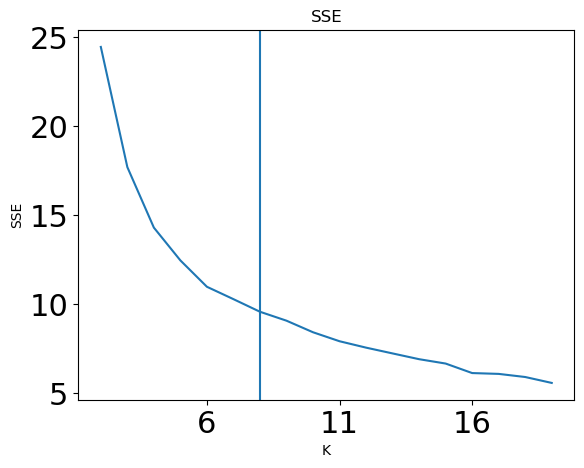

In [2079]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SSE')
plt.axvline(8)
plt.show()

In this case we choose K = 8 as we can deduct from the knee method.

In [2080]:
best_n_clusters = 8
best_kmeans = kmeans_list[best_n_clusters-2]

Now we show the timeseries for each cluster

(4, 2)


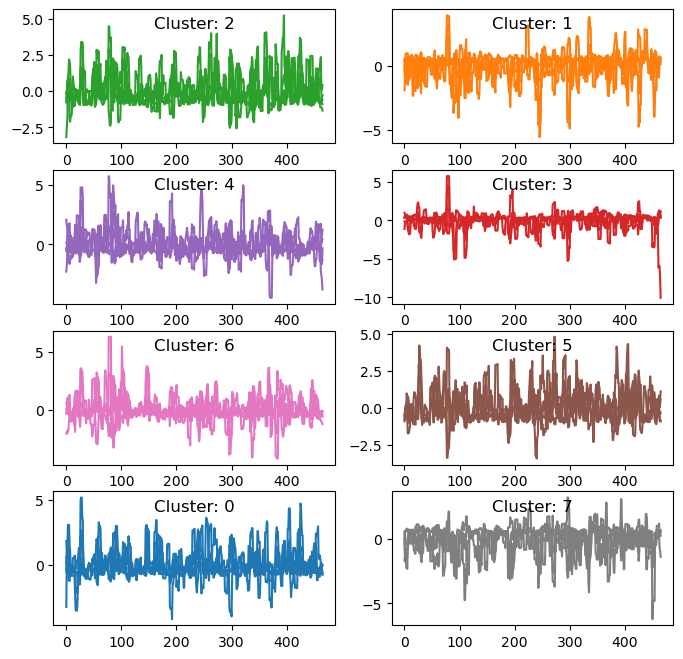

In [2081]:
plot_timeseries_per_cluster(best_kmeans.labels_, best_n_clusters)

#### Hierachical

In [2082]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fclusterdata

Use both Z-score and minmax normalization.

In [2083]:
from sklearn.discriminant_analysis import StandardScaler

In [2084]:
scaler = StandardScaler()
X_std = scaler.fit_transform(timeseries_features)

In [2085]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(timeseries_features)

##### With minmax normalization


In [2086]:
config_hierarchical_minmax = []

Show generated dendrogram for hierarchical clustering with selected params and the best threshold for that dendrogram.

We search for thresholds that generate **8 clusters** as its a values that's proven good earlier.

Method: complete, threshold: 0.72

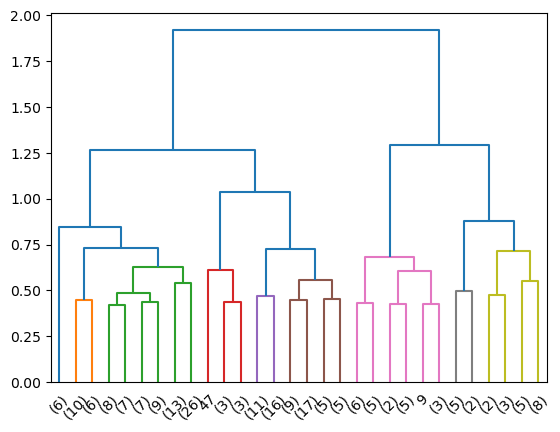

In [2087]:
data_dist = pdist(X_minmax, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.72, truncate_mode='lastp')
plt.show()
config_hierarchical_minmax.append((0.72, 'euclidean', 'complete'))

method: ward, threshold: 1.1

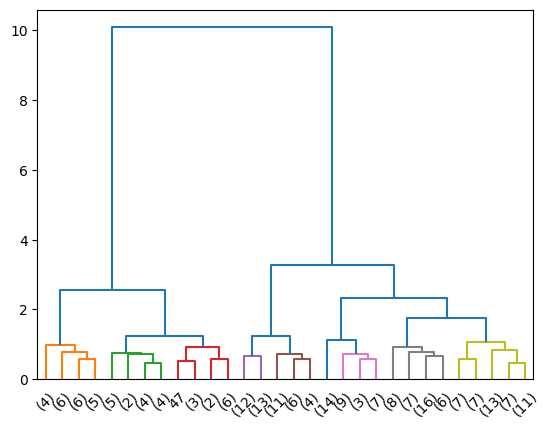

In [2088]:
data_dist = pdist(X_minmax, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, color_threshold=1.1, truncate_mode='lastp')
plt.show()
config_hierarchical_minmax.append((1.1, 'euclidean', 'ward'))

method: average, threshold: 0.43

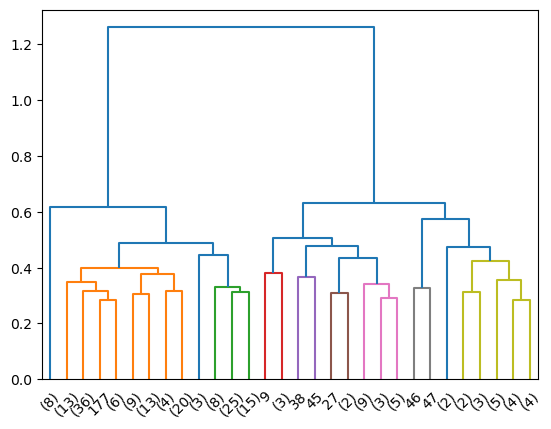

In [2089]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.43, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minmax.append((0.43, 'euclidean', 'average'))

method: centroid, threshold: 0.365

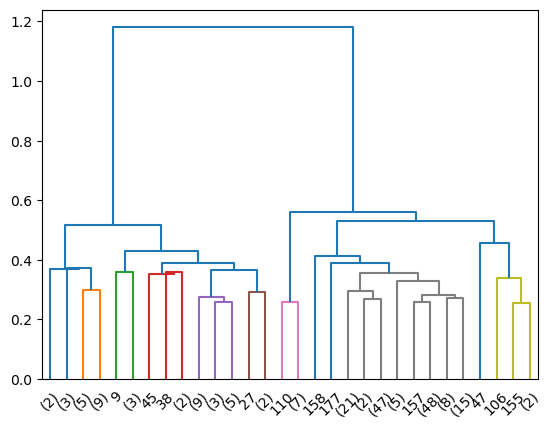

In [2090]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='euclidean')
data_link = linkage(data_dist, method='centroid', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.365, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minmax.append((0.365, 'euclidean', 'centroid'))

Fit clusterings with params found by exploring dendrograms

In [2091]:
cluster_list_minmax = []
for treshold, metric_minmax, method_minmax in config_hierarchical_minmax:
    cluster = fclusterdata(X=X_minmax,
     t=treshold , criterion='distance', metric=metric_minmax, method=method_minmax)
    cluster_list_minmax.append(cluster)

Calculate Silhouette for each clustering.

In [2092]:
for i, clustering in enumerate(cluster_list_minmax):
    threshold, metric, method = config_hierarchical_minmax[i]
    n_clusters = len(np.unique(clustering))
    occ_list = []
    for k in range(1, n_clusters+1):
        occ_list.append(np.count_nonzero(clustering == k))

    try: # Exception in case of num_clusters=1
        silhouette = silhouette_score(X_minmax, clustering)
    except:
        silhouette = np.nan
    print("MINMAX - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", n_clusters)
    print('Clusters Size:', occ_list)
    print('')

MINMAX - dist: euclidean , method: complete , SILHOUTTE: 0.15551561235794142 , n_clusters: 9
Clusters Size: [6, 16, 70, 7, 27, 36, 22, 7, 18]

MINMAX - dist: euclidean , method: ward , SILHOUTTE: 0.20558473644774236 , n_clusters: 9
Clusters Size: [21, 15, 12, 25, 21, 14, 19, 37, 45]

MINMAX - dist: euclidean , method: average , SILHOUTTE: 0.19395165092354577 , n_clusters: 11
Clusters Size: [8, 102, 3, 48, 4, 2, 3, 17, 2, 2, 18]

MINMAX - dist: euclidean , method: centroid , SILHOUTTE: 0.030759105484986143 , n_clusters: 13
Clusters Size: [2, 3, 14, 4, 4, 17, 3, 8, 147, 1, 1, 4, 1]



##### With mean-std normalization


In [2093]:
config_hierarchical_std = []

Show generated dendrogram for hierarchical clustering with selected params and the best threshold for that dendrogram.

method: complete, threshold: 4.8

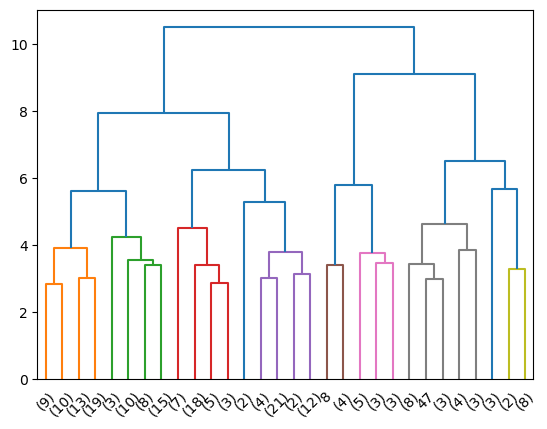

In [2094]:
# Generate dendrogram
data_dist = pdist(X_std, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=4.8, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((4.8, 'euclidean', 'complete'))

method: ward, threshold: 2.8

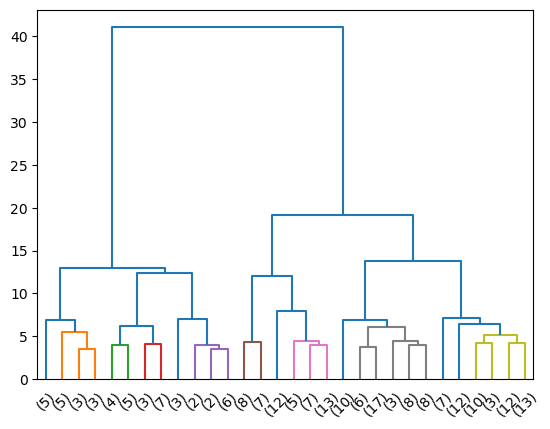

In [2095]:
# Generate dendrogram
data_dist = pdist(X_std, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, color_threshold=6.2, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((6.2, 'euclidean', 'ward'))

method: average, threshold: 3

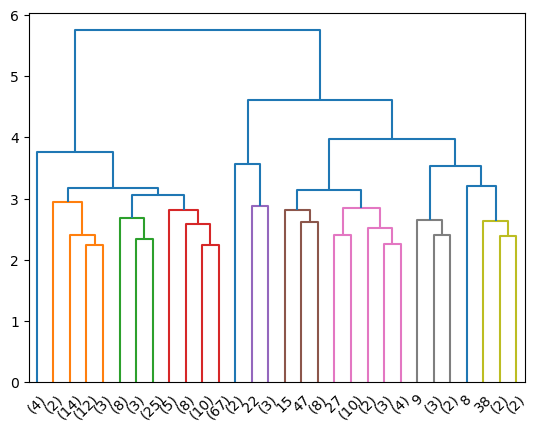

In [2096]:
# Generate dendrogram
data_dist = pdist(X_std, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=3, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((3, 'euclidean', 'average'))

method: centroid, threshold: 2.25

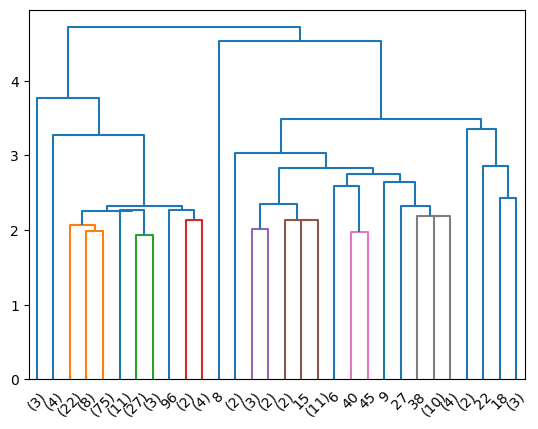

In [2097]:
# Generate dendrogram
data_dist = pdist(X_std, metric='euclidean')
data_link = linkage(data_dist, method='centroid', metric='euclidean')
res = dendrogram(data_link, color_threshold=2.25, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((2.25, 'euclidean', 'centroid'))

Fit clusterings with params found by exploring dendrograms

In [2098]:
cluster_list_std = []
for treshold, metric_std, method_std in config_hierarchical_std:
    cluster = fclusterdata(X=X_std,
     t=treshold , criterion='distance', metric=metric_std, method=method_std)
     
    cluster_list_std.append(cluster)

Calculate Silhouette for each clustering.

In [2099]:
for i, clustering in enumerate(cluster_list_std):
    treshold, metric, method = config_hierarchical_std[i]
    n_clusters = len(np.unique(clustering))
    occ_list = []
    for k in range(1, n_clusters+1):
        occ_list.append(np.count_nonzero(clustering == k))

    try: # Exception in case of num_clusters=1
        silhouette = silhouette_score(X_std, clustering)
    except:
        silhouette = np.nan
    print("STD - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", n_clusters)
    print('Clusters Size:', occ_list)
    print('')

STD - dist: euclidean , method: complete , SILHOUTTE: 0.1927685332748409 , n_clusters: 10
Clusters Size: [51, 36, 33, 2, 39, 5, 11, 19, 3, 10]

STD - dist: euclidean , method: ward , SILHOUTTE: 0.17445719516102615 , n_clusters: 14
Clusters Size: [5, 11, 9, 10, 3, 10, 15, 12, 25, 10, 42, 7, 12, 38]

STD - dist: euclidean , method: average , SILHOUTTE: 0.19301714948151213 , n_clusters: 11
Clusters Size: [4, 31, 36, 90, 2, 4, 10, 20, 6, 5, 1]

STD - dist: euclidean , method: centroid , SILHOUTTE: 0.09008468549929984 , n_clusters: 20
Clusters Size: [3, 4, 105, 11, 30, 6, 1, 2, 5, 14, 2, 1, 15, 1, 1, 2, 3, 1, 1, 1]



The final chosen hierarchical cluster selected is the one with **ward** method and **minmax** normalization, as it has an appropriate number of clusters and elements for each clusters, a dendrogram with well distanciated branches and relatively higher Silhouette for its number of clusters.

In [2100]:
best_hierarchical = np.array(cluster_list_minmax[1]-1)
best_n_clusters = len(np.unique(best_hierarchical))

In [2101]:
silhouette = silhouette_score(X_minmax, best_hierarchical)
print("Silhouette Score:", silhouette)

Silhouette Score: 0.20558473644774236


We plot the timeseries for the hierarchical clustering with with **ward** method and **std** normalization.

(5, 2)


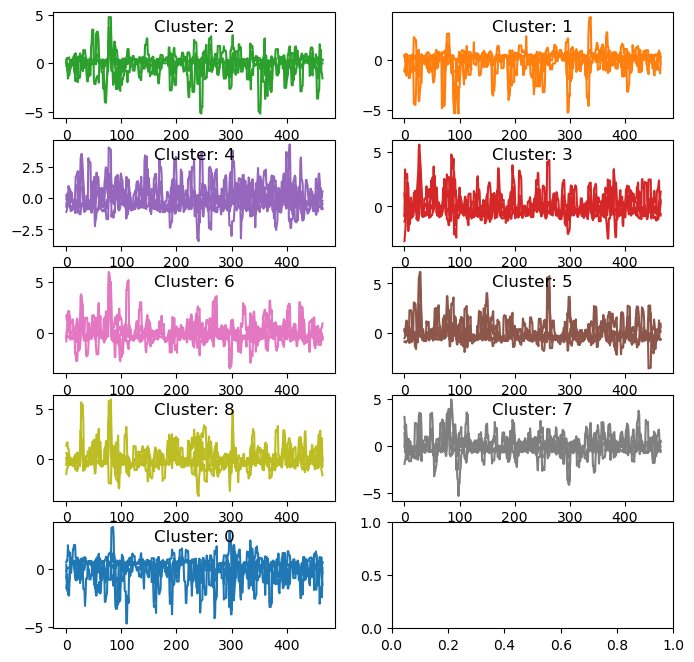

In [2102]:
plot_timeseries_per_cluster(best_hierarchical, best_n_clusters)

Hierarchical seems to have clusters which have less coincidence in the positions of spikes, compared to KMeans.

### Compression based clustering

In [2103]:
from tslearn.piecewise import PiecewiseAggregateApproximation

We use PAA as the compression algorithm.

In [2104]:
n_paa_segments = 16
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(timeseries_data)

/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 209 1-dimensional timeseries
  warnings.warn(


Show PAA transformed timeseries.

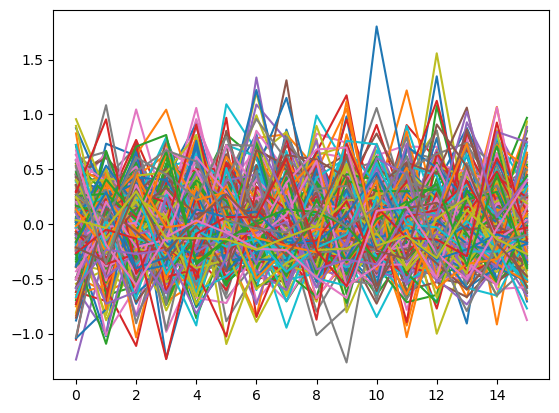

In [2105]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

In [2106]:
def TSKMeansFunction (X, n_clusters_list, n_init_value, max_iter_value=5):
    kmeans_list = list()

    for numCluster in tqdm(n_clusters_list):
        # Define and fit K-Means
        kmeans = TimeSeriesKMeans(n_clusters=numCluster, n_init=n_init_value, max_iter=max_iter_value, random_state=0, metric='euclidean')
        kmeans.fit(X)
        kmeans_list.append(kmeans)
    
    return kmeans_list

In [2107]:
# Params for kmeans
clusters_list = [x for x in range(2, 21)]
init_value = 5
iter_value = 10

kmeans_list = TSKMeansFunction (X_minmax, clusters_list, init_value, iter_value)

sse_list = []
for i, kmeans in enumerate(kmeans_list):
    sse_list.append(kmeans.inertia_)
    print_clusters(kmeans.labels_, clusters_list[i], kmeans)

100%|██████████| 19/19 [00:04<00:00,  4.47it/s]

k =  2 | Clusters = [161  48] | Inertia = 0.11696679197833494
k =  3 | Clusters = [84 48 77] | Inertia = 0.08466263397621789
k =  4 | Clusters = [77 25 23 84] | Inertia = 0.06845637594421926
k =  5 | Clusters = [44 25 42 23 75] | Inertia = 0.05972038267128499
k =  6 | Clusters = [38 25 33 46 23 44] | Inertia = 0.05298824504371091
k =  7 | Clusters = [41 24 17 23 39 30 35] | Inertia = 0.0490769371438374
k =  8 | Clusters = [14  5 33 20 34 22 33 48] | Inertia = 0.04600566779285502
k =  9 | Clusters = [31  7 21 41 15 32 16 10 36] | Inertia = 0.04332417364867479
k =  10 | Clusters = [21 21 26 16 12 32 15 31 16 19] | Inertia = 0.040378776527859525
k =  11 | Clusters = [18 22 15 19 16 19 14 15 23 34 14] | Inertia = 0.03847203017304347
k =  12 | Clusters = [27 20 21 18  7 17 14 16 19 26 17  7] | Inertia = 0.037116298530904916
k =  13 | Clusters = [18  5 21 15 31 13 28 15 16  6 17 15  9] | Inertia = 0.034560062811437774
k =  14 | Clusters = [ 3 22 13 12 22 17 15 31  9 10  6 21  7 21] | Inertia

Now we plot the SSE curve to help the choice of the best K.

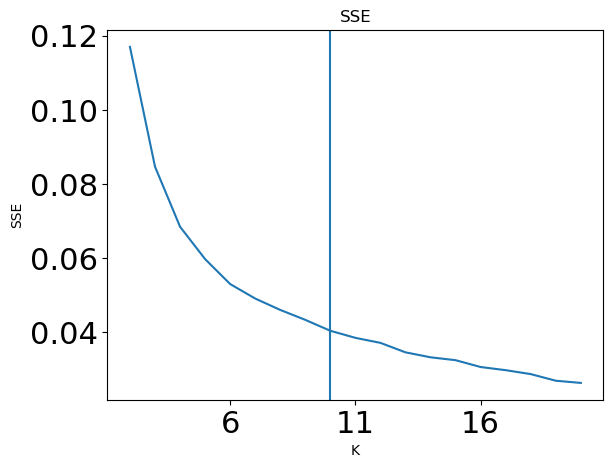

In [2108]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SSE')
plt.axvline(10)
plt.show()

The best K according to the SSE knee method is K=10

In [2109]:
best_n_clusters = 10
best_kmeans = kmeans_list[best_n_clusters-2]

In [2110]:
silhouette = silhouette_score(X_minmax, best_kmeans.labels_)
print("Silhouette Score:", silhouette)

Silhouette Score: 0.22711252925500788


Now we show the timeseries for each cluster

(5, 2)


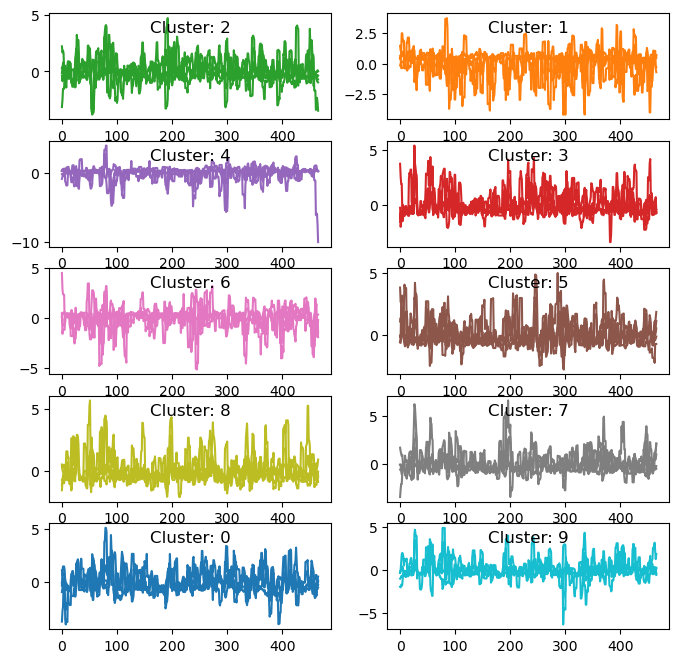

In [2111]:
plot_timeseries_per_cluster(best_kmeans.labels_, best_n_clusters)

Show cluster centers for each cluster of the compressed timeseries next to the cluster means of the original timeseries.

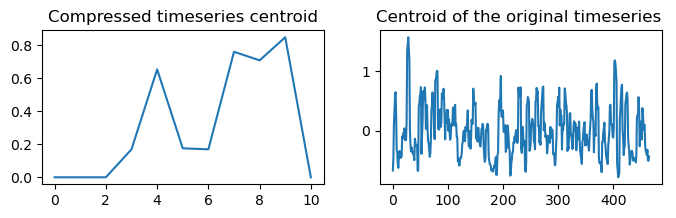

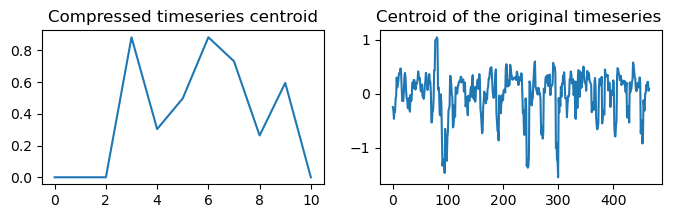

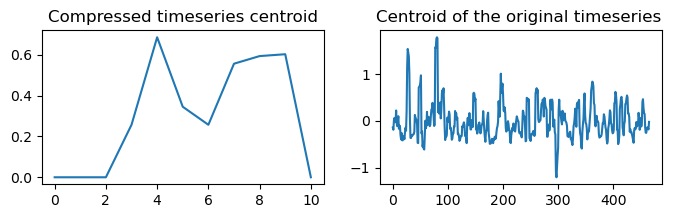

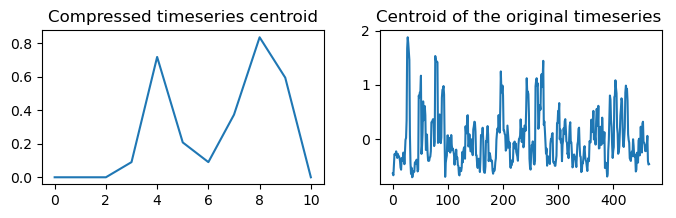

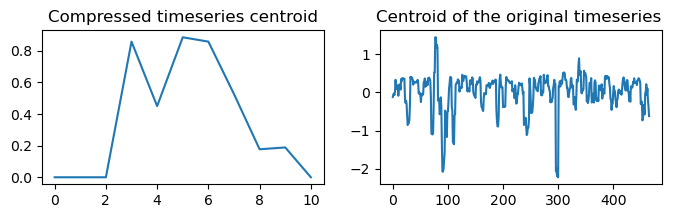

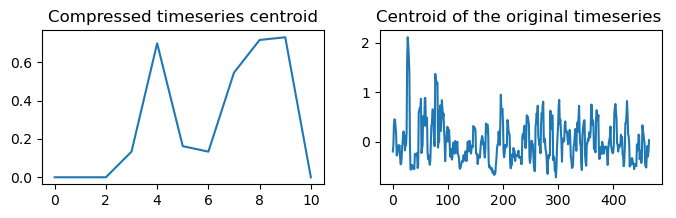

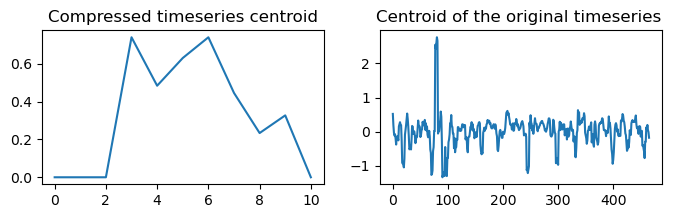

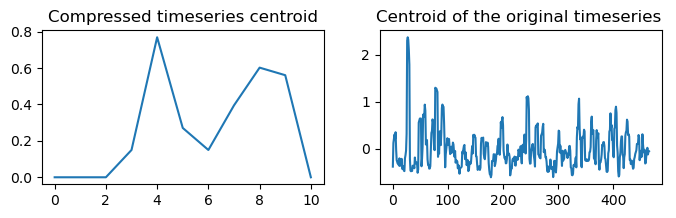

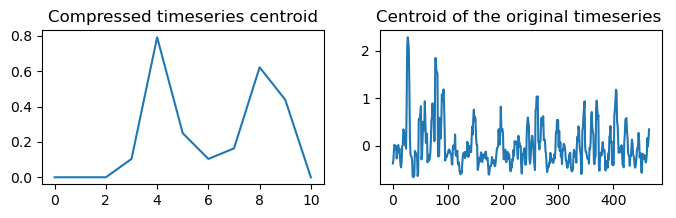

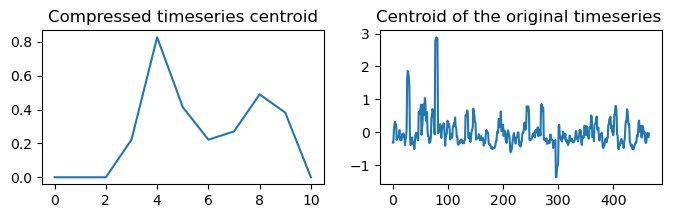

In [2112]:
for c in range(best_n_clusters):
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(best_kmeans.cluster_centers_[c])#.reshape(X_paa.shape[1], best_n_clusters))
    ax1.set_title("Compressed timeseries centroid")

    ax2.plot(np.mean(timeseries_data[np.where(best_kmeans.labels_ == c)], axis=0))
    ax2.set_title("Centroid of the original timeseries ")
    
    fig.set_size_inches(8, 2)
    plt.show()

## Clustering Conclusions

Of the methods used for clustering, the one which, subjected to further analysis, produced the best results was the Shape-Based K-Means with Euclidean metric.

# Motifs and Shapelets

In [2113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matrixprofile import *

In [2115]:
time_series_analysed = time_series_analysed.pivot(index='city_or_county', columns=['year', 'week'], values='severity_score')

# Replace NaN values with a specific fill value, for example, -1
time_series_analysed.fillna(-1, inplace=True)

# Convert the DataFrame to a NumPy array
time_series_analysed = time_series_analysed.to_numpy()

time_series_analysed

array([[ -0.5645933 ,  -0.5645933 ,  -0.5645933 , ...,  -0.5645933 ,
          1.4354067 ,  -0.5645933 ],
       [ -1.4569378 , -12.4569378 ,  -1.4569378 , ...,  -1.4569378 ,
          6.0430622 ,   1.0430622 ],
       [  0.4138756 ,   0.4138756 ,   0.4138756 , ...,   2.9138756 ,
          1.9138756 , -10.5861244 ],
       ...,
       [ -1.08373206,  -1.58373206,  -1.08373206, ...,   4.41626794,
         -3.08373206,   2.41626794],
       [ -2.32057416,  -2.32057416,  -2.32057416, ...,   0.17942584,
         -0.32057416,   0.17942584],
       [ -0.13636364,  -0.13636364,   0.86363636, ...,  -0.13636364,
         -0.13636364,   3.86363636]])

In [2116]:
# time_series_data = filtered_cities.values
time_series_data = time_series_analysed
time_series_data

array([[ -0.5645933 ,  -0.5645933 ,  -0.5645933 , ...,  -0.5645933 ,
          1.4354067 ,  -0.5645933 ],
       [ -1.4569378 , -12.4569378 ,  -1.4569378 , ...,  -1.4569378 ,
          6.0430622 ,   1.0430622 ],
       [  0.4138756 ,   0.4138756 ,   0.4138756 , ...,   2.9138756 ,
          1.9138756 , -10.5861244 ],
       ...,
       [ -1.08373206,  -1.58373206,  -1.08373206, ...,   4.41626794,
         -3.08373206,   2.41626794],
       [ -2.32057416,  -2.32057416,  -2.32057416, ...,   0.17942584,
         -0.32057416,   0.17942584],
       [ -0.13636364,  -0.13636364,   0.86363636, ...,  -0.13636364,
         -0.13636364,   3.86363636]])

In [2117]:
w = 12
ts = time_series_data[:,16]
mp, mpi = matrixProfile.stomp(ts, w)

### Motif discovery
Parameters
- max_motifs: stop finding new motifs once we have max_motifs
- radius: For each motif found, find neighbors that are within radius*motif_mp of the first.
- n_neighbors: number of neighbors from the first to find. If it is None, find all.
- ex_zone: minimum distance between indices for after each subsequence is identified. Defaults to m/2 where m is the subsequence length. If ex_zone = 0, only the found index is exclude, if ex_zone = 1 then if idx is found as a motif idx-1, idx, idx+1 are excluded.


The function returns a tuple (top_motifs, distances) which are lists of the same length.

- top_motifs: This is a list of the indices found for each motif. The first index is the nth motif followed by all nearest neighbors found sorted by distances.
- distances: Minimum Matrix profile value for each motif set.

In [2118]:
mo, mod  = motifs.motifs(ts, (mp, mpi), max_motifs=5)

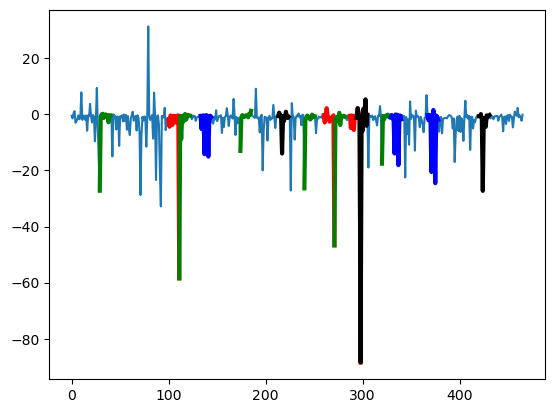

In [2119]:
plt.plot(ts)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

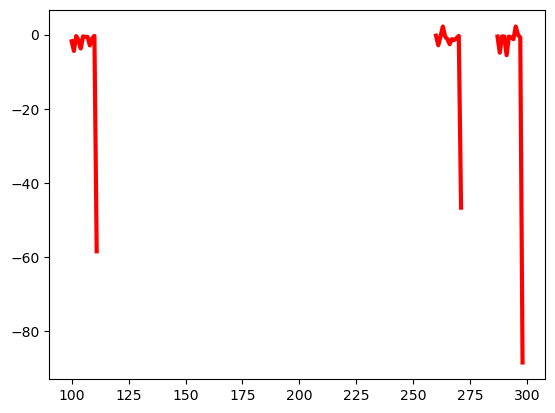

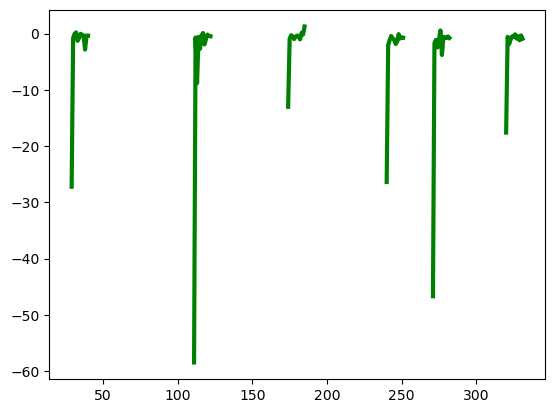

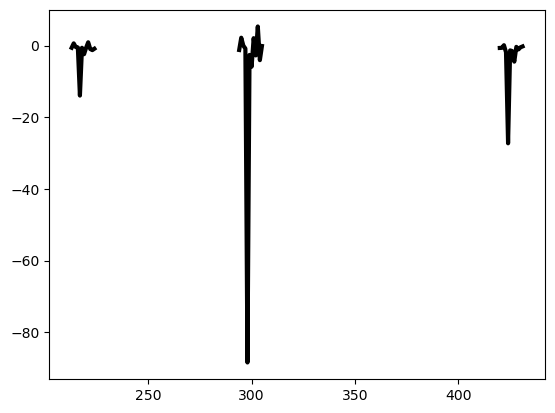

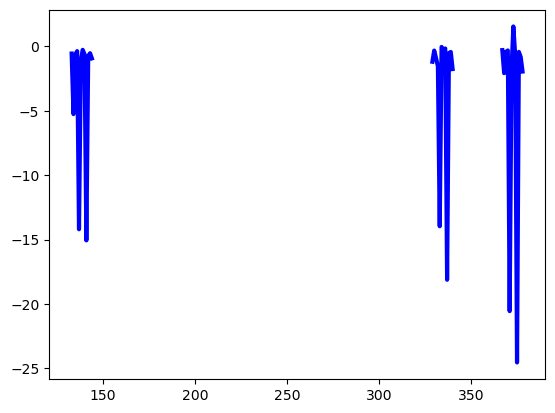

In [2120]:
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.show()

### Anomaly Discovery
Parameters  
- mp: matrix profile numpy array
- k: the number of discords to discover
- ex_zone: the number of samples to exclude and set to Inf on either side of a found discord   


Returns a list of indexes represent the discord starting locations. MaxInt indicates there were no more discords that could be found due to too many exclusions or profile being too small. Discord start indices are sorted by highest matrix profile value.

In [2121]:
from matrixprofile.discords import discords
anoms = discords(mp, ex_zone=3, k=5)

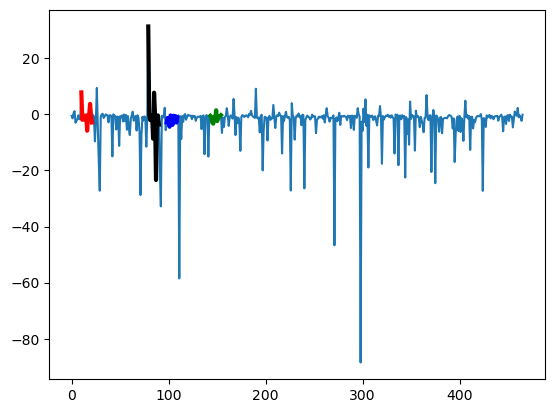

In [2122]:
plt.plot(ts)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for a, c in zip(anoms, colors):
    a_shape = ts[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)

plt.show()

## Shaplet discovery

In [2123]:
from tslearn.shapelets import LearningShapelets
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.preprocessing import TimeSeriesScalerMinMax
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2124]:
labels = result_df.values

In [2125]:
result_df.head()

,isKilled
city_or_county,
Abilene,False
Aiken,False
Akron,True
Albany,False
Albuquerque,True


In [2126]:
filtered_cities.head()

year           2014                                                            \
week             1     2    3     4     5    6    7    8    9    10   11   12   
city_or_county                                                                  
Abilene        -1.0  -1.0 -1.0  -1.0  -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   
Aiken          -1.0 -12.0 -1.0  -1.0  -1.0 -1.0 -1.0 -1.0 -1.0 -3.0 -6.0 -1.5   
Akron          -1.0  -1.0 -1.0 -18.0  -1.0 -1.0 -1.0 -1.0 -1.0  1.5 -1.0 -6.0   
Albany          1.0  -1.0 -3.0  -1.0  -1.5 -1.0  7.0  1.0 -1.0 -1.0 -3.0 -1.0   
Albuquerque     1.0  -1.0 -1.0  -2.5 -13.5 -1.0 -1.0 -1.0 -6.0  1.5 -9.0  0.0   

year                                                                         \
week              13    14    15   16   17   18   19    20    21   22    23   
city_or_county                                                                
Abilene         -1.0  -1.0  -1.0 -1.0 -1.0 -1.0 -1.0  -1.0  -1.0  5.0  10.5   
Aiken           -1.0  -1.0  -1.0 -1.0 -1.0 -1.0 -2.0  -1.0  -1.0 -1.0   0.0   
Akron           -6.0 -13.5 -14.0 -6.0 -1.0 -1.0 -1.5  -1.0  -2.0 -6.0 -30.0   
Albany         -12.5  -1.0   2.5 -5.0  2.0 -7.5  2.5 -21.0 -24.0  1.0  -9.5   
Albuquerque     -1.0  -1.0  -1.0 -1.0  0.0 -1.0 -1.0  -1.0  -6.0 -1.0  -1.0   

year                                                                          \
week             24   25   26   27    28    29    30    31    32    33    34   
city_or_county                                                                 
Abilene         6.0 -1.0 -1.0 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0 -13.5  -1.0   
Aiken          -1.0 -1.0 -1.0 -1.0  -1.0  -1.0  -1.0 -30.0  -1.0  -1.0  -1.0   
Akron           0.0 -5.0 -1.0 -6.5 -31.0  -8.0 -23.5 -25.5 -13.5 -24.0  18.0   
Albany         -1.0  5.0  2.0  1.0   1.5 -24.0  -4.0   0.0  -1.0  -1.0  -1.5   
Albuquerque    -1.0 -1.0 -7.5 -1.5  -1.0  -9.0 -15.0  -9.0 -28.5 -10.0 -43.5   

year                                                                         \
week             35    36   37    38    39    40   41    42    43   44   45   
city_or_county                                                                
Abilene        -1.0  -6.0 -1.0  -1.0  -1.0  -1.0 -1.0  -1.0  -1.0  6.0 -1.0   
Aiken          -1.0  -1.0 -1.0  -1.0  -1.0  -1.5 -1.5  -5.0   0.0 -1.0 -1.0   
Akron          -1.0 -10.0 -8.0  -1.0  -1.5  -3.0 -1.0  -1.0  -1.0 -1.0  0.0   
Albany         -3.0   0.5 -1.0 -14.5 -10.5  -5.0 -1.0 -18.0  -7.0 -2.5  1.0   
Albuquerque    -9.0  -2.0 -1.0  -2.5 -15.0 -13.5  6.0  -3.0 -11.5 -0.5 -1.0   

year                                                2015                  \
week              46   47   48   49   50    51   52   1    2    3     4    
city_or_county                                                             
Abilene         -1.0 -1.0 -1.0 -1.0 -1.0  -1.0  9.0 -1.0 -1.0 -1.0  -1.0   
Aiken           -1.0  0.0 -1.0  1.0  1.5  -1.0  1.5 -1.0  2.5 -1.0   6.5   
Akron           30.0 -1.0 -1.0 -1.5 -1.0   1.5 -1.0  1.5  1.5  5.0  12.0   
Albany          -6.0 -1.0 -1.0 -1.0  2.0   2.5  1.5  1.5  1.5  1.5   1.0   
Albuquerque     -1.0 -3.0 -2.0 -1.0 -1.0  16.5  3.0  1.0  1.0  3.0   2.5   

year                                                                         \
week              5     6    7    8    9     10    11    12   13    14   15   
city_or_county                                                                
Abilene         -1.0  -1.0 -1.0 -1.0 -1.0   1.0  -1.0  -1.0 -1.0  -1.0 -1.0   
Aiken           -6.0  21.0 -1.0  1.5  7.5  12.0   1.5 -24.0 -1.0 -20.0 -1.0   
Akron           -1.0  -1.0  9.0 -1.0 -1.5  -1.0  -1.0  -4.0 -4.5 -10.5 -6.0   
Albany           1.5   0.0 -1.0 -1.0  1.5   7.0   1.5   1.5 -1.0   1.0 -1.0   
Albuquerque     43.5  -9.0  3.0  3.0  3.0   1.5  15.5   1.5  1.5   1.5  8.0   

year                                                                         \
week              16    17   18    19   20    21    22    23   24   25   26   
city_or_county                              

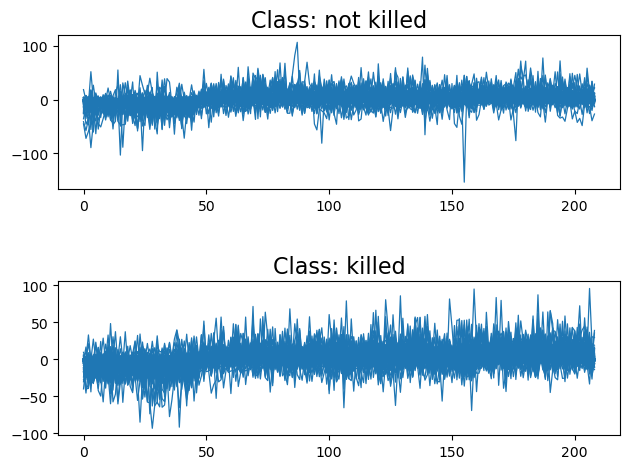

In [2127]:
plt.figure()
for i, classe in enumerate(['not killed', 'killed']):
    plt.subplot(2, 1, i + 1)
    mask = labels.T == i
    for x in time_series_data[mask[0]]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
plt.show()

In [2128]:
X_train, X_test, y_train, y_test = train_test_split(time_series_data, labels,
 test_size=0.25, random_state=1000, stratify = labels)

In [2129]:
print(X_train.shape)
print(X_test.shape)

(349, 209)
(117, 209)


Use grabocka method to identify the number of shapelets for each shapelet size

In [2130]:
n_ts, ts_sz = X_train.shape
n_classes = 2

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.06,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 349
ts_sz 209
n_classes 2
shapelet_sizes {12: 4}


In [ ]:
param_grid = {
    'n_shapelets_per_size': [shapelet_sizes],
    'optimizer': tf.keras.optimizers.legacy.Adam(.01),
    'batch_size': [8, 16, 32],
    'weight_regularizer': [0.001, 0.005, 0.01],
    'max_iter': [5, 10, 15],
    'random_state': [42],
    'verbose': [1]
}

best_params = None
best_accuracy = 0.0

for n_shapelets_per_size in param_grid['n_shapelets_per_size']:
    for batch_size in param_grid['batch_size']:
        for weight_regularizer in param_grid['weight_regularizer']:
            for max_iter in param_grid['max_iter']:
                for random_state in param_grid['random_state']:
                    for verbose in param_grid['verbose']:
                        # Create the LearningShapelets classifier with the current parameters
                        shp_clf = LearningShapelets(
                            n_shapelets_per_size=n_shapelets_per_size,
                            optimizer=tf.keras.optimizers.legacy.Adam(.01),
                            batch_size=batch_size,
                            weight_regularizer=weight_regularizer,
                            max_iter=max_iter,
                            random_state=random_state,
                            verbose=verbose
                        )
                        # Train the model on the training set
                        shp_clf.fit(X_train, y_train)
                        # Make predictions on the validation set
                        y_pred = shp_clf.predict(X_test)
                        # Calculate accuracy on the validation set
                        accuracy = accuracy_score(y_test, y_pred)
                        # Update the best parameters if the current model is better
                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_params = {
                                'n_shapelets_per_size': n_shapelets_per_size,
                                'optimizer': tf.keras.optimizers.legacy.Adam(.01),
                                'batch_size': batch_size,
                                'weight_regularizer': weight_regularizer,
                                'max_iter': max_iter,
                                'random_state': random_state,
                                'verbose': verbose
                            }

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", best_params)
print("Best Accuracy: ", best_accuracy)

Build the shapelet model to extract shapelet. We use shapelet sizes and numbers from previous grabocka method.

In [2132]:
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=32,
                            weight_regularizer=.001,
                            max_iter=15,
                            random_state=42,
                            verbose=1)

/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Fit the shapelet model

In [ ]:
shp_clf.fit(X_train, y_train)

Predict on test

In [2134]:
y_pred_test = shp_clf.predict(X_test)
predicted_locations = shp_clf.locate(X_test)

4/4 [==============================] - 0s 850us/step


In [2135]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.57      0.47      0.51        58
        True       0.56      0.66      0.60        59

    accuracy                           0.56       117
   macro avg       0.57      0.56      0.56       117
weighted avg       0.57      0.56      0.56       117



Print all the shapelets

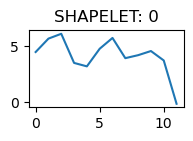

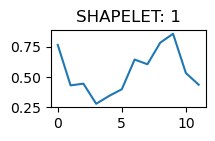

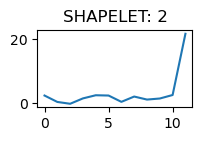

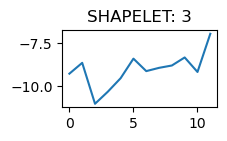

In [2136]:
len(shp_clf.shapelets_as_time_series_)
for i, shp in enumerate(shp_clf.shapelets_as_time_series_):
    plt.figure(figsize=(2,1))
    plt.title(f"SHAPELET: {i}")
    plt.plot(shp)
    plt.show()

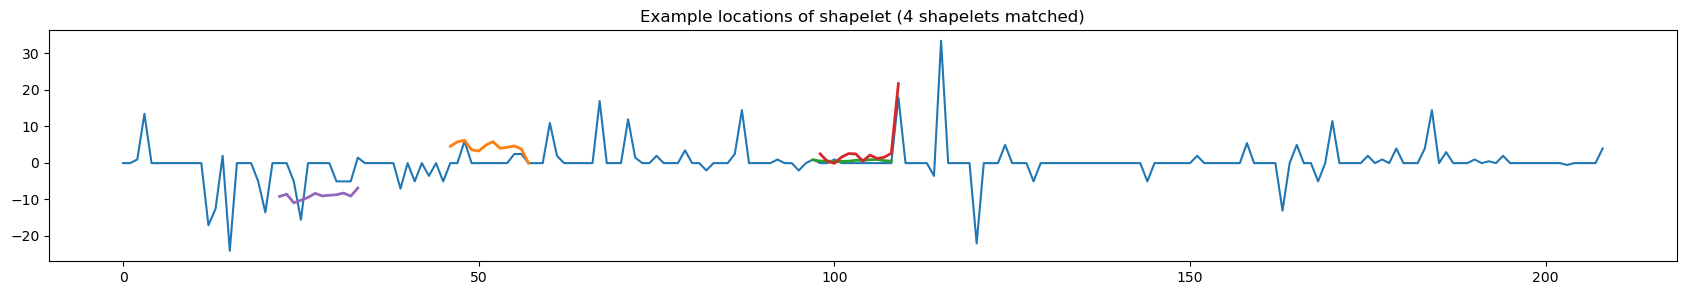

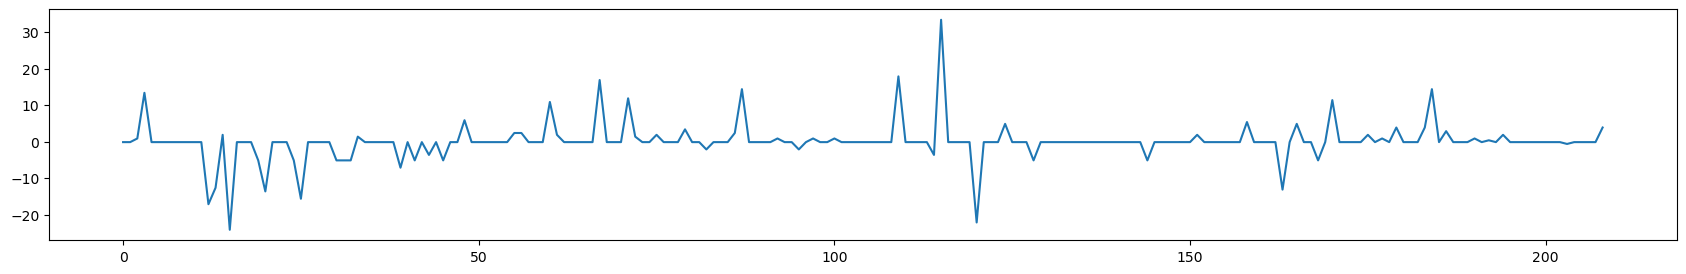

In [2137]:
ts_id = 1
plt.figure(figsize=(21.,3.))
n_shapelets = sum(shapelet_sizes.values())

plt.plot(X_test[ts_id].ravel())
count = 0
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    if t0 > 0:
        plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)
        count+=1
plt.title("Example locations of shapelet ({} shapelets matched)".format(count))

plt.show()
plt.figure(figsize=(21.,3.))
plt.plot(X_test[ts_id].ravel())
plt.show()
